In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [101]:
from numpy import *
from numpy.random import *
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli
import pyparticleest.interfaces as interfaces
from scipy.optimize import newton

import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg

In [3]:
def measure(X, Y, trial):
    # log-pdf of p(y_t|x_t)
    T = X.shape[0]
    N = X.shape[1]
    coefficient = scipy.special.binom(trial,Y)
    return np.reshape(np.repeat(np.log(coefficient), N), [T,N]) + X * np.reshape(np.repeat(Y, N), [T,N]) - trial * np.log(1+np.exp(X))

In [4]:
def gaussian(X, Q):
    #log-pdf of p(x_t|x_{t-1})
    return -0.5 * (l2pi + np.log(Q) + (X ** 2) / Q)

In [121]:
def resample(weights):
  n = len(weights)
  indices = []
  C = [0.] + [sum(weights[:i+1]) for i in range(n)]
  u0, j = random(), 0
  for u in [(u0+i)/n for i in range(n)]:
    while u > C[j]:
      j+=1
    indices.append(j-1)
  return indices

In [130]:
#df = pd.read_csv('thaldata.csv',header=None)
#Y = df.values.reshape(3000)
#Y = Y[500:800]
#T = len(Y)
mat = np.loadtxt('train_data.txt')
Y = mat[:,1:]
T = Y.shape[1]
n = Y.shape[0]

In [131]:
# Forward particles
N = 1000
# Backward trajectories
M = 30
# 
P0 = 0.01
#trial

trial = 50
#
l2pi = math.log(2 * math.pi)
#
square2pi = np.sqrt(2 * math.pi)
#
j = 19

In [132]:
sigma = np.arange(0.01, 1.51, 0.01)

# Filtering

In [133]:
mode = np.empty(T+1)
variance = np.empty(T+1)
mode[0] = -2
variance[0] = P0

In [134]:
loglikelihood = np.empty(len(sigma))

In [135]:
def filtering(Y, Q, mode, variance):
    samples = np.random.normal(0,1,[T+1,N])
    X = np.reshape (np.repeat(mode,N),[T+1,N]) + samples * np.reshape (np.repeat(np.sqrt(variance),N),[T+1,N])
    w = measure(X[1:], Y, trial) + gaussian(np.diff(X, axis = 0), Q) - gaussian(X[1:]-np.reshape (np.repeat(mode[1:], N) ,[T,N]), np.reshape (np.repeat(variance[1:], N) ,[T,N]))
    W = np.exp(w - np.reshape(np.repeat(np.max(w, axis =1), N), [T,N])) 
    W = W/ np.reshape(np.repeat(np.sum(W, axis =1), N), [T,N])
    #ancestor = np.empty([T,N])
    #for t in range(T):
    #    ancestor[t,:]= X[t,resample(W[t,:])]
        
    #return X, w, W, ancestor
    return X, w, W

In [136]:
#%%time
for i in range(len(sigma)):
    Q = sigma[i]
    for tt in range(T):
        t = tt+1
        variance_tmp = variance[t-1] + Q
        mode[t] = mode[t-1] + variance_tmp *(Y[j,t-1] - trial * np.exp(mode[t-1])/(1.0 + np.exp(mode[t-1])))
        variance[t] = 1.0/(1.0/(variance_tmp) + trial * np.exp(mode[t])/(1.0 + np.exp(mode[t]))**2 )

    [X, w, W] = filtering(Y[j,:], Q, mode, variance)
    maxlogweight = np.max(w, axis=1)
    weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
    loglikelihood[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)

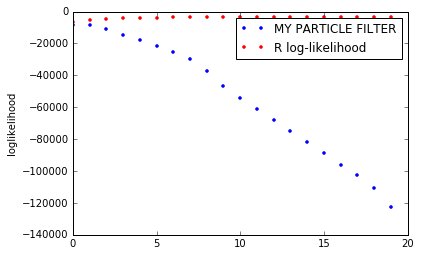

In [138]:
Y_19= pd.read_csv('row_19_ll.csv',header=0)
y19 = Y_19.values.reshape(1500,2)
y_19 = np.empty(150)
for i in range(150):
    y_19[i]= np.sum(y19[10*i:10*(i+1),1])/10.0

plt.plot(loglikelihood[:20], '.',linewidth=2.0, label='MY PARTICLE FILTER')
plt.plot(y_19[:20], 'r.',linewidth=2.0, label='R log-likelihood')
plt.ylabel('loglikelihood')
plt.legend(loc='best')

(array([ 708.,   21.,   21.,   14.,   12.,    8.,   10.,    7.,    7.,
           6.,   10.,    8.,    6.,    4.,    6.,    5.,    6.,    6.,
           4.,    8.,    8.,    4.,   14.,    9.,    4.,   12.,   15.,
           4.,    7.,    1.,    4.,    4.,    5.,    3.,    1.,    3.,
           3.,    2.,    2.,    0.,    0.,    3.,    0.,    3.,    1.,
           0.,    2.,    1.,    0.,    1.,    1.,    0.,    1.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    1.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    1.]),
 array([  4.06914196e-112,   1.91805830e-004,   3.83611660e-004,
          5.75417490e-004,   7.67223320e-004,   9.59029150e-004,
          1.15083498e-003,   1.34264081e-003,   1.53444664e-003,
          1.726

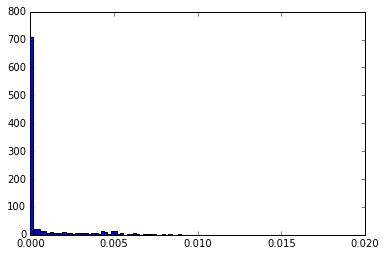

In [120]:
plt.hist(W[1000,:],100)

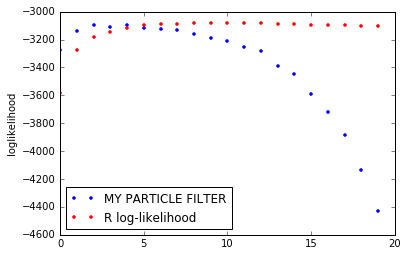

In [100]:
ll_from_R = np.loadtxt('ll_from_R.txt')
plt.plot(loglikelihood[0:20], '.',linewidth=2.0, label='MY PARTICLE FILTER')
plt.plot(ll_from_R[0:20], 'r.',linewidth=2.0, label='R log-likelihood')
plt.ylabel('loglikelihood')
plt.legend(loc='best')

In [94]:
ll_from_R = np.loadtxt('ll_from_R.txt')
plt.plot(sigma, loglikelihood, '.',linewidth=2.0, label='MY PARTICLE FILTER')
plt.plot(sigma, ll_from_R, 'r.',linewidth=2.0, label='R log-likelihood')

#plt.ylim([-4000,-3500])
plt.ylabel('loglikelihood')
plt.xlabel(r'$\sigma^2$')
plt.legend(loc='best')

ValueError: operands could not be broadcast together with shapes (3001,) (3001,1000) 

In [ ]:
X[1,resample(W[1,:])]

In [148]:
samples = np.random.normal(0,1,[T+1,N])
X = np.reshape (np.repeat(mode,N),[T+1,N]) + samples * np.reshape (np.repeat(variance,N),[T+1,N])

In [150]:
w = measure(X[1,:], Y, trial) + gaussian(np.diff(X, axis = 0), Q) - np.reshape(kalman.lognormpdf_scalar(X[1:]-np.reshape (np.repeat(mode[1:], N) ,[T,N]), np.reshape (np.repeat(variance[1:], N) ,[T,N])), [T,N])

In [151]:
W = np.exp(w - np.reshape(np.repeat(np.max(w, axis =1), N), [T,N])) 

In [155]:
W = W/ np.reshape(np.repeat(np.sum(W, axis =1), N), [T,N])

In [ ]:
np.random.normal(0,1,N)

In [14]:
np.sum(np.log(np.sum(np.exp(w), axis = 1)/N))

2485.8845503902749

In [24]:
loglikelihood

-5944.5496526321649

In [164]:
ancestor = np.empty([T,N])
for t in range(T):
    ancestor[t,:]= X[t,resample(W[t,:])]

In [28]:
ancestor[T-1]

array([-4.07402689, -4.07402689, -4.62161135, -4.62161135, -3.82937921,
       -4.64416526, -5.44521653, -4.55326894, -4.55326894, -4.25170025,
       -5.1369329 , -4.97154807, -4.97154807, -4.7125548 , -4.7125548 ,
       -4.7125548 , -5.4634475 , -5.20377705, -5.20377705, -5.20377705,
       -5.20377705, -4.65962812, -4.65962812, -6.2068784 , -6.2068784 ,
       -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 ,
       -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 ,
       -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 ,
       -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 ,
       -6.2068784 , -6.2068784 , -6.2068784 , -6.2068784 , -4.57977684,
       -4.57977684, -4.2348785 , -5.29372226, -4.27076248, -4.66479788,
       -5.07013971, -5.07013971, -5.07013971, -5.07013971, -4.1081466 ,
       -4.1081466 , -3.91095545, -3.92041899, -4.63103906, -3.98917619,
       -3.98917619, -3.98917619, -5.82944266, -4.8872374 , -4.88